# Gradient Boosted model with state and action vectors as input

## Import Libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from load_data import load_data
from evaluate import evaluate_model
from plot_degradation import plot_degradation

## Load Data

In [50]:
df = load_data("03-22-24", "B1.csv")
df.columns.values

array(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', '|Energy|/W.h',
       'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'Q charge/discharge/mA.h',
       'half cycle', 'Energy charge/W.h', 'Energy discharge/W.h',
       'Capacitance charge/µF', 'Capacitance discharge/µF', 'step time/s',
       'z cycle', 'Re(Z)/Ohm', 'Im(Z)/Ohm', 'Re(Y)/Ohm-1', 'Im(Y)/Ohm-1',
       '|Y|/Ohm-1', 'Phase(Y)/deg', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%', 'control/V',
       'control/mA', 'cycle number', 'P/W', 'R/Ohm'], dtype=object)

## Preprocess

- Filter by frequency
- I am currently unsure of whether to do >0 or > 0.2
- For now I will do 0.2 to be consistent with previous studies

In [51]:
df = df[(df['freq/Hz'] > 0.2) & (df['freq/Hz'] <= 20000)]
unique_freqs = np.array(df['freq/Hz'].unique())
unique_freqs.sort()

print(unique_freqs)

[2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.76e+01 7.50e+01 9.06e+01 1.02e+02 1.22e+02 1.35e+02
 1.63e+02 1.78e+02 2.19e+02 2.37e+02 2.94e+02 3.16e+02 3.94e+02 4.22e+02
 5.29e+02 5.64e+02 7.10e+02 7.50e+02 9.52e+02 1.00e+03 1.28e+03 1.33e+03
 1.71e+03 1.78e+03 2.30e+03 2.37e+03 3.09e+03 3.16e+03 4.14e+03 4.22e+03
 5.56e+03 5.62e+03 7.45e+03 7.50e+03 1.00e+04]


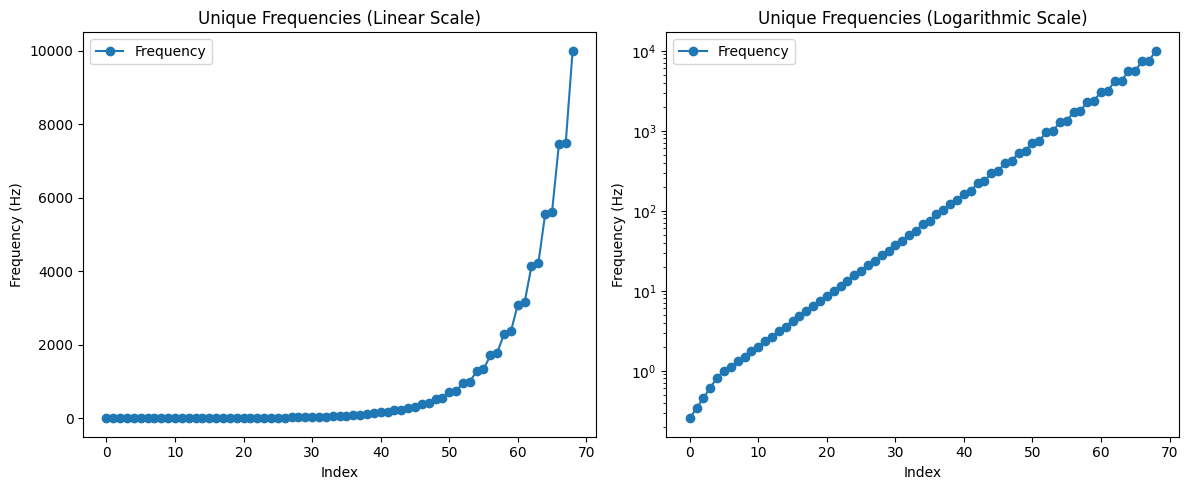

In [52]:
plt.figure(figsize=(12, 5))

# Linear scale plot
plt.subplot(1, 2, 1)
plt.plot(unique_freqs, 'o-', label='Frequency')
plt.xlabel('Index')
plt.ylabel('Frequency (Hz)')
plt.title('Unique Frequencies (Linear Scale)')
plt.legend()

# Logarithmic scale plot (y-axis on log scale)
plt.subplot(1, 2, 2)
plt.semilogy(unique_freqs, 'o-', label='Frequency')
plt.xlabel('Index')
plt.ylabel('Frequency (Hz)')
plt.title('Unique Frequencies (Logarithmic Scale)')
plt.legend()

plt.tight_layout()
plt.show()


We can see above that the unique frequencies are spaced out logarithmically, therefore we will interpolate logarithmically

### Confirm Degradation

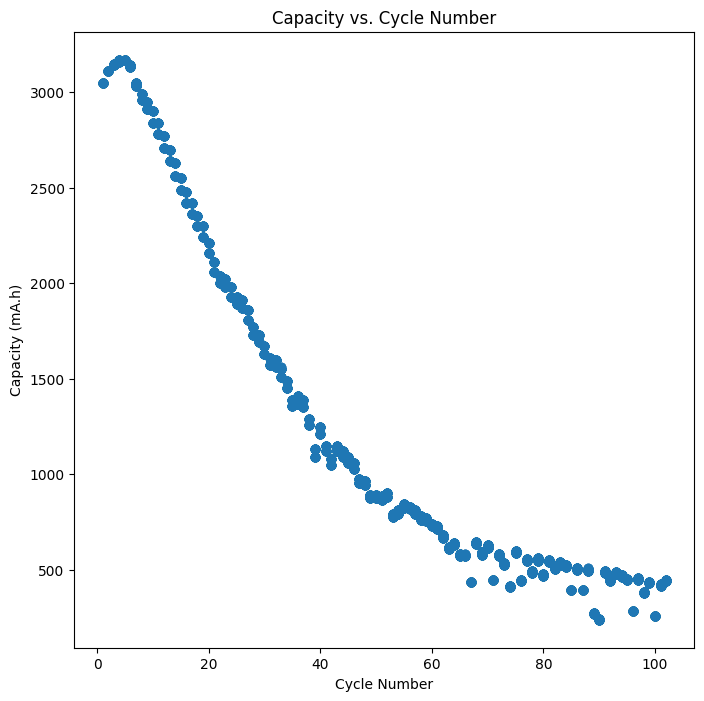

In [53]:
plot_degradation(df)

In [32]:
# Assuming df is your DataFrame
unique_freqs_by_cycle = {}

all_cycles = sorted(df['cycle number'].unique())
for cycle in all_cycles:
    cycle_freqs = np.sort(df[df['cycle number'] == cycle]['freq/Hz'].unique())
    unique_freqs_by_cycle[cycle] = cycle_freqs
    print(f"Cycle {cycle} frequency points: {cycle_freqs}")

# Compute the intersection of frequency sets
common_freqs = set(unique_freqs_by_cycle[all_cycles[0]])
for cycle in all_cycles:
    common_freqs = common_freqs.intersection(set(unique_freqs_by_cycle[cycle]))

print("Common frequency points across all cycles:", np.sort(list(common_freqs)))


Cycle 1.0 frequency points: [2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.76e+01 7.50e+01 9.06e+01 1.02e+02 1.22e+02 1.35e+02
 1.63e+02 1.78e+02 2.19e+02 2.37e+02 2.94e+02 3.16e+02 3.94e+02 4.22e+02
 5.29e+02 5.64e+02 7.10e+02 7.50e+02 9.52e+02 1.00e+03 1.28e+03 1.33e+03
 1.71e+03 1.78e+03 2.30e+03 2.37e+03 3.09e+03 3.16e+03 4.14e+03 4.22e+03
 5.56e+03 5.62e+03 7.45e+03 7.50e+03 1.00e+04]
Cycle 2.0 frequency points: [2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.

In [49]:
unique_counts_by_cycle = {}

# Get a sorted list of unique cycle numbers.
all_cycles = sorted(df['cycle number'].unique())

# Loop through each cycle, count, and print the unique frequencies.
for cycle in all_cycles:
    # Filter the DataFrame for the current cycle and count unique frequencies
    unique_count = len(np.unique(df[df['cycle number'] == cycle]['freq/Hz']))
    unique_counts_by_cycle[cycle] = unique_count
    print(f"Cycle {cycle} has {unique_count} unique frequency points.")


Cycle 1.0 has 69 unique frequency points.
Cycle 2.0 has 69 unique frequency points.
Cycle 3.0 has 69 unique frequency points.
Cycle 4.0 has 69 unique frequency points.
Cycle 5.0 has 69 unique frequency points.
Cycle 6.0 has 69 unique frequency points.
Cycle 7.0 has 69 unique frequency points.
Cycle 8.0 has 69 unique frequency points.
Cycle 9.0 has 69 unique frequency points.
Cycle 10.0 has 69 unique frequency points.
Cycle 11.0 has 69 unique frequency points.
Cycle 12.0 has 69 unique frequency points.
Cycle 13.0 has 69 unique frequency points.
Cycle 14.0 has 69 unique frequency points.
Cycle 15.0 has 69 unique frequency points.
Cycle 16.0 has 69 unique frequency points.
Cycle 17.0 has 69 unique frequency points.
Cycle 18.0 has 69 unique frequency points.
Cycle 19.0 has 69 unique frequency points.
Cycle 20.0 has 69 unique frequency points.
Cycle 21.0 has 69 unique frequency points.
Cycle 22.0 has 69 unique frequency points.
Cycle 23.0 has 69 unique frequency points.
Cycle 24.0 has 69 un

### Building the Input
- We need a state and action vector
- State Vector $s_{n}$ - concatenated impedance values at 57 different frequencies 0.02Hz - 20kHz

### Make state vector FOR EACH CYCLE

- Build EIS-based state vectors from the given dataframe.
- Returns a dictionary keyed by cycle, where each value is another dict:
```
      {
            "labeled_impedance": dict of { "Z_re(freqHz)": val, "Z_im(freqHz)": val, ... },
            "state_vector": np.ndarray (the concatenated real+imag EIS data)
      }
```

In [34]:
from scipy.interpolate import interp1d

def interpolation(df: pd.DataFrame) -> np.ndarray:
    """
    Generates a common frequency grid using logarithmic spacing.
    The number of points in the grid is determined by the maximum unique
    frequency points found across all cycles in the dataframe.
    """
    # Determine the maximum number of unique frequency points in any cycle.
    max_points = df.groupby('cycle number')['freq/Hz'].nunique().max()
    num_points = int(max_points)
    
    # Global minimum and maximum frequency across the dataset.
    global_min = df['freq/Hz'].min()
    global_max = df['freq/Hz'].max()
    
    # Create a logarithmically spaced grid between global_min and global_max.
    common_freq_grid = np.logspace(np.log10(global_min), np.log10(global_max), num_points)
    # print(f"Common Frequency Grid: {common_freq_grid}")
    
    # Plot the common grid for visual confirmation.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(common_freq_grid, 'o-', label='Frequency')
    plt.xlabel('Index')
    plt.ylabel('Frequency (Hz)')
    plt.title('Common Frequency Grid (Linear Scale)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.semilogy(common_freq_grid, 'o-', label='Frequency')
    plt.xlabel('Index')
    plt.ylabel('Frequency (Hz)')
    plt.title('Common Frequency Grid (Log Scale)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return common_freq_grid

In [43]:
def build_eis_data_by_cycle(df: pd.DataFrame):
    """
    Processes the dataframe to build an EIS state vector for each cycle.
    The state vector is built by interpolating the EIS data (Re and Im impedance)
    onto a common log-spaced frequency grid and then normalizing the values.
    """
    eis_data_by_cycle = {}
    
    # Obtain a common frequency grid based on the entire dataset.
    common_freq_grid = interpolation(df)
   
    # Process each cycle separately.
    all_cycles = df['cycle number'].unique()
    
    for cycle in sorted(all_cycles):
        # Filter data for the current cycle.
        df_cycle_data = df[df['cycle number'] == cycle].copy()
        
        # Keep only rows where EIS measurements are taken (Ns=1 or 6).
        df_cycle_eis_data = df_cycle_data[df_cycle_data['Ns'].isin([1, 6])].copy()
        
        # If no EIS data exists for this cycle, skip it.
        if df_cycle_eis_data.empty:
            eis_data_by_cycle[cycle] = {"labeled_impedance": {}, "state_vector": np.array([])}
            continue
        
        # Sort the data by frequency.
        df_cycle_eis_data.sort_values(by='freq/Hz', ascending=True, inplace=True)
        
        # extract real and imaginary resistance values
        freq_array = df_cycle_eis_data['freq/Hz'].values
        z_re_array = df_cycle_eis_data['Re(Z)/Ohm'].values
        z_im_array = df_cycle_eis_data['Im(Z)/Ohm'].values

        # Convert frequency to log scale
        log_freq_array = np.log10(freq_array)
        log_common_freq_grid = np.log10(common_freq_grid)

        # Remove duplicates in log_freq_array
        unique_log_freq, unique_idx = np.unique(log_freq_array, return_index=True)
        # Select corresponding impedance values
        unique_z_re = z_re_array[unique_idx]
        unique_z_im = z_im_array[unique_idx]

        # Create interpolation functions in log space using 'cubic'
        f_interp_re = interp1d(unique_log_freq, unique_z_re, kind='cubic', fill_value='extrapolate')
        f_interp_im = interp1d(unique_log_freq, unique_z_im, kind='cubic', fill_value='extrapolate')

        # Interpolate the impedance values onto the common frequency grid (in log space)
        z_re_interp = f_interp_re(log_common_freq_grid)
        z_im_interp = f_interp_im(log_common_freq_grid)
        
        # Normalize the interpolated impedance data using Z-score normalization.
        z_re_interp_norm = (z_re_interp - np.mean(z_re_interp)) / np.std(z_re_interp)
        z_im_interp_norm = (z_im_interp - np.mean(z_im_interp)) / np.std(z_im_interp)
        
        # Build a labeled dictionary for debugging/inspection.
        labeled_impedance = {}
        for freq_val, re_val, im_val in zip(common_freq_grid, z_re_interp_norm, z_im_interp_norm):
            freq_str = f"{freq_val:.5g}"
            labeled_impedance[f"Z_re({freq_str}Hz)"] = re_val
            labeled_impedance[f"Z_im({freq_str}Hz)"] = im_val
        
        # Concatenate the normalized real and imaginary parts into one state vector.
        state_vector = np.concatenate([z_re_interp_norm, z_im_interp_norm])
        eis_data_by_cycle[cycle] = {"labeled_impedance": labeled_impedance, "state_vector": state_vector}
    
    return eis_data_by_cycle


### Action vector Data

- Build action (usage) vectors from the given dataframe.
- Typically, we treat positive I/mA as charge and negative as discharge.
- Returns a dictionary keyed by cycle, each containing a 6-element np.array: 
-     [i_charge_avg, total_charge_time, q_charge, i_discharge_avg, total_discharge_time, q_discharge]

In [44]:
def build_action_data_by_cycle(df: pd.DataFrame):
    """
    Processes the dataframe to build an action vector for each cycle.
    In addition to basic features (average current, total time, net capacity), this
    version also extracts energy features and cycle efficiency.
    """
    action_data_by_cycle = {}
    all_cycles = df['cycle number'].unique()

    for cycle in sorted(all_cycles):
        df_cycle_data = df[df['cycle number'] == cycle].copy()

        # Separate charge and discharge data based on the sign of the current.
        df_charge_data = df_cycle_data[df_cycle_data['I/mA'] > 0].copy()
        df_discharge_data = df_cycle_data[df_cycle_data['I/mA'] < 0].copy()

        # ---- Charging Features ----
        if not df_charge_data.empty:
            i_charge_avg = df_charge_data['I/mA'].mean()
            total_charge_time = df_charge_data['step time/s'].sum()
            q_charge = df_charge_data['Q charge/mA.h'].max() - df_charge_data['Q charge/mA.h'].min()
            energy_charge = df_charge_data['Energy charge/W.h'].sum()
        else:
            i_charge_avg = total_charge_time = q_charge = energy_charge = 0.0

        # ---- Discharging Features ----
        if not df_discharge_data.empty:
            i_discharge_avg = df_discharge_data['I/mA'].mean()
            total_discharge_time = df_discharge_data['step time/s'].sum()
            q_discharge = df_discharge_data['Q discharge/mA.h'].max() - df_discharge_data['Q discharge/mA.h'].min()
            energy_discharge = df_discharge_data['Energy discharge/W.h'].sum()
        else:
            i_discharge_avg = total_discharge_time = q_discharge = energy_discharge = 0.0

        # ---- Overall Cycle Efficiency ----
        efficiency_avg = df_cycle_data['Efficiency/%'].mean() if not df_cycle_data.empty else 0.0

        # ---- Construct Enhanced Action Vector ----
        # Features: [avg_charge_current, total_charge_time, net_charge, energy_charge,
        #            avg_discharge_current, total_discharge_time, net_discharge, energy_discharge, efficiency]
        usage_action_vector = np.array([
            i_charge_avg,
            total_charge_time,
            q_charge,
            energy_charge,
            i_discharge_avg,
            total_discharge_time,
            q_discharge,
            energy_discharge,
            efficiency_avg
        ], dtype=float)

        action_data_by_cycle[cycle] = usage_action_vector

    return action_data_by_cycle


### Combine State and Action vectors
#### Combine EIS-based state vectors and usage-based action vectors to form final (X, y) arrays.

Returns:
```
      X (np.ndarray): 2D array of shape (num_valid_cycles, dim_state + dim_action).
      y (np.ndarray): 1D array of discharge capacities for each cycle.
```

In [45]:
def build_combined_dataset(df: pd.DataFrame, eis_data_by_cycle: dict, action_data_by_cycle: dict):
    """
    Combines the state (EIS) and action vectors into a single feature vector per cycle.
    The target is taken as the maximum discharge capacity (Q discharge) for each cycle.
    """
    X_list = []
    y_list = []
    
    # Dynamically determine the expected length of the EIS state vector.
    expected_state_vec_length = None
    for cycle, data in eis_data_by_cycle.items():
        state_vec = data.get("state_vector")
        if state_vec is not None and len(state_vec) > 0:
            expected_state_vec_length = len(state_vec)
            break
    if expected_state_vec_length is None:
        raise ValueError("No valid state vectors found in eis_data_by_cycle!")
    
    # Consider only cycles present in both dictionaries.
    common_cycles = sorted(set(eis_data_by_cycle.keys()) & set(action_data_by_cycle.keys()))
    
    for cycle in common_cycles:
        state_vec = eis_data_by_cycle[cycle]["state_vector"]
        if len(state_vec) != expected_state_vec_length:
            print(f"Skipping cycle {cycle}: EIS vector length {len(state_vec)} != expected {expected_state_vec_length}")
            continue
        
        action_vec = action_data_by_cycle[cycle]
        # Concatenate the state vector (EIS features) and the action vector (cycling protocol features).
        combined_input = np.concatenate([state_vec, action_vec])
        
        # The target y is defined as the maximum discharge capacity for that cycle.
        df_cycle = df[df['cycle number'] == cycle]
        if df_cycle.empty:
            print(f"Skipping cycle {cycle}: no data in df.")
            continue
        Q_n = df_cycle['Q discharge/mA.h'].max()
        if pd.isna(Q_n):
            print(f"Skipping cycle {cycle}: Q_n is NaN.")
            continue
        
        X_list.append(combined_input)
        y_list.append(Q_n)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print("Final dataset shapes:")
    print("  X:", X.shape)
    print("  y:", y.shape)
    return X, y

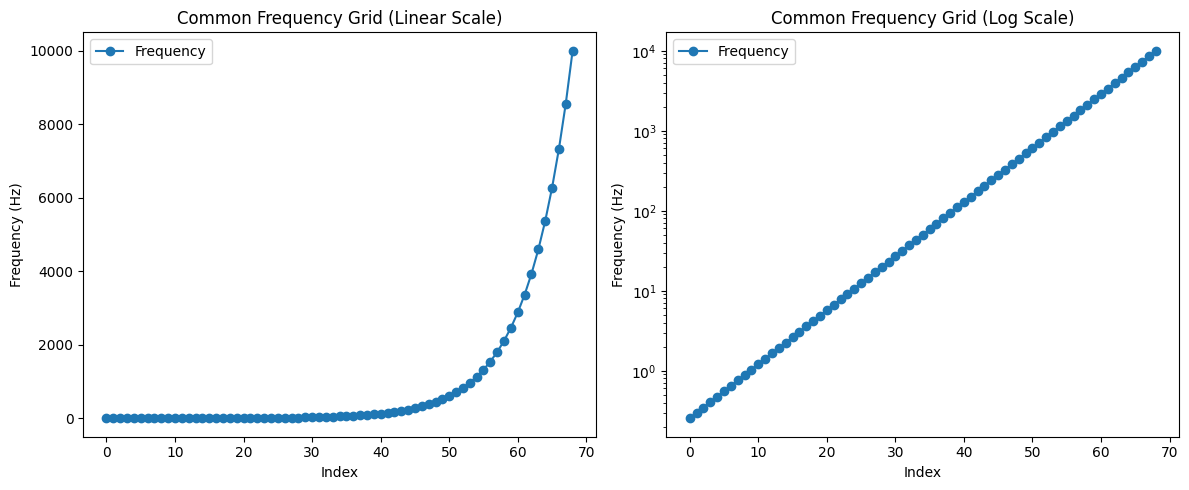

Final dataset shapes:
  X: (48, 147)
  y: (48,)
X shape: (48, 147)
y shape: (48,)


In [46]:
# Build EIS data, action data, then combine to (X, y)
eis_data_by_cycle = build_eis_data_by_cycle(df)
action_data_by_cycle = build_action_data_by_cycle(df)
X, y = build_combined_dataset(df, eis_data_by_cycle, action_data_by_cycle)

print("X shape:", X.shape)
print("y shape:", y.shape)


In [36]:
eis_data_by_cycle[1]["state_vector"]

array([ 2.05153077e+00,  1.91400854e+00,  1.86449091e+00,  1.82273223e+00,
        1.70939326e+00,  1.56738205e+00,  1.67412380e+00,  1.79707522e+00,
        9.92201220e-01,  8.80550316e-01,  1.05952205e+00,  9.67846375e-01,
        8.86750014e-01,  1.00161603e+00,  7.33208493e-01,  1.00819649e+00,
        6.03476657e-01,  9.25819656e-01,  5.33226162e-01,  8.03719856e-01,
        5.26583426e-01,  6.56124151e-01,  4.78544429e-01,  5.56402483e-01,
        4.30066670e-01,  4.50059393e-01,  3.57089757e-01,  3.56391531e-01,
        2.44320114e-01,  2.83930039e-01,  1.16853461e-01,  1.92146256e-01,
       -2.15365981e-02,  1.22018169e-01, -1.11845560e-01, -4.20821141e-03,
       -2.14089263e-01, -1.32898423e-01, -3.13839347e-01, -2.71952421e-01,
       -3.75731301e-01, -4.45585267e-01, -4.08662201e-01, -6.09821420e-01,
       -5.01566482e-01, -7.32972970e-01, -6.19390151e-01, -8.43230857e-01,
       -7.59790523e-01, -9.44464300e-01, -8.48015597e-01, -9.96663218e-01,
       -1.00937546e+00, -

### VERY IMPORTANT NOTES FOR NICK: filtering out NS= 1,6 is the EIS data which is good for building the state vector, however when building the action vector we would want all of the information 

## Algorithm and Model

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# X.shape -> (num_samples, num_features)
# y.shape -> (num_samples,)

# Feeding all models the same data

num_ensemble = 10
models = []
for i in range(num_ensemble):
    gb_model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=1,
        learning_rate=0.1,
        random_state=42 + i  # Use different seed for each model
    )
    models.append(gb_model)


In [17]:
# Let's do a simple train/test split to demonstrate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train each model
for m in models:
    m.fit(X_train, y_train)

# Get predictions from each model.
preds_ensemble = [model.predict(X_test) for model in models]
preds_ensemble = np.array(preds_ensemble)

# Compute ensemble predictions: mean and standard deviation.
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std = np.std(preds_ensemble, axis=0)

In [18]:
# Evaluate

from evaluate import evaluate_model

rmse, r2, mse, mae = evaluate_model(y_test, y_pred_mean)
print(f"RMSE: {rmse}\nR2: {r2}\nMSE: {mse}\nMAE: {mae}")


RMSE: 6.197094991101609
R2: 0.9939272633888778
MSE: 38.40398632873665
MAE: 5.535590481389454


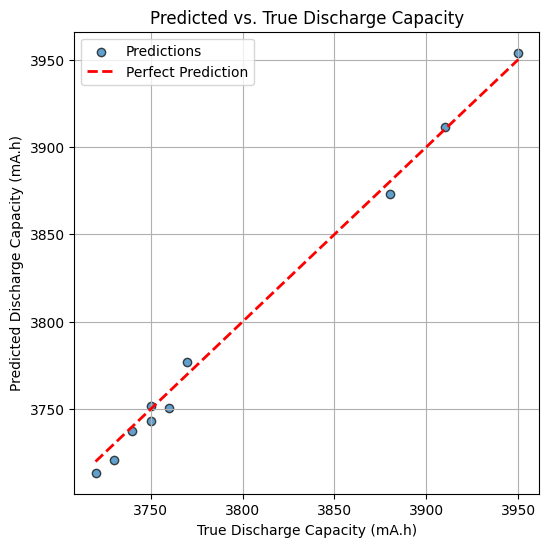

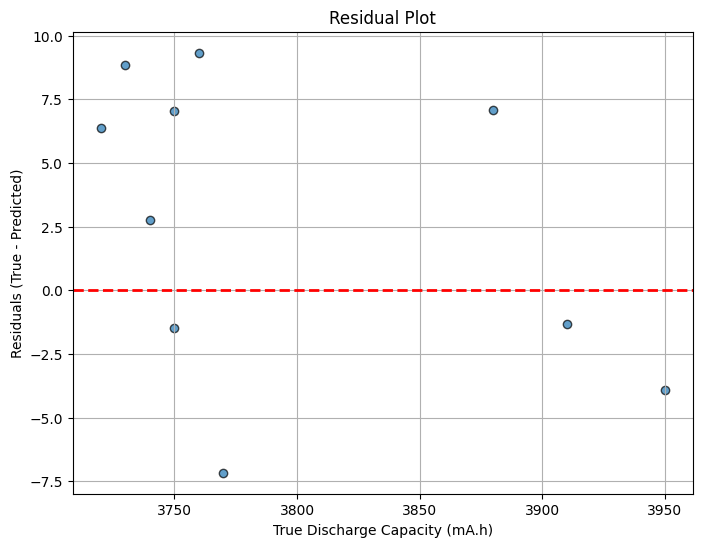

In [19]:
# Assume y_test are the true target values and y_pred_mean are your ensemble predictions.
# Also assume y_pred_std contains your ensemble standard deviation estimates.

# Scatter plot: Predicted vs. True
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_mean, alpha=0.7, edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Discharge Capacity (mA.h)')
plt.ylabel('Predicted Discharge Capacity (mA.h)')
plt.title('Predicted vs. True Discharge Capacity')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot: Error vs. True values
residuals = y_test - y_pred_mean
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('True Discharge Capacity (mA.h)')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


In [20]:
print("Predictions shape:", y_pred_mean.shape)
print("Uncertainty shape (std):", y_pred_std.shape)


Predictions shape: (10,)
Uncertainty shape (std): (10,)


### Attempting to test the model against other datasets

In [20]:
import joblib

In [21]:
# Suppose you have your list of models: models = [model1, model2, ... model10]
joblib.dump(models, "../models/gb_ensemble.pkl")

['../models/gb_ensemble.pkl']

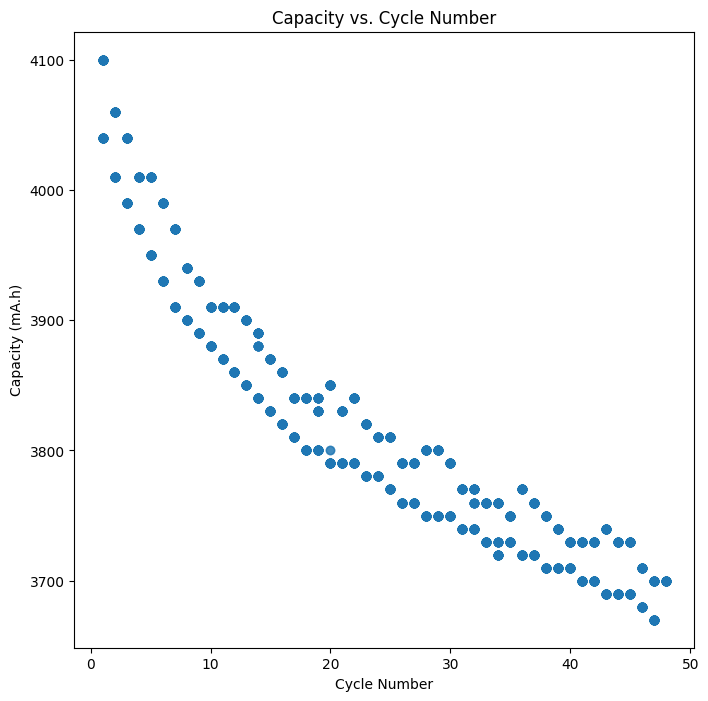

In [22]:
df = load_data("03-06-24", "A2.csv")
df = df[(df['freq/Hz'] > 0.2) & (df['freq/Hz'] <= 20000)]
  
plot_degradation(df)

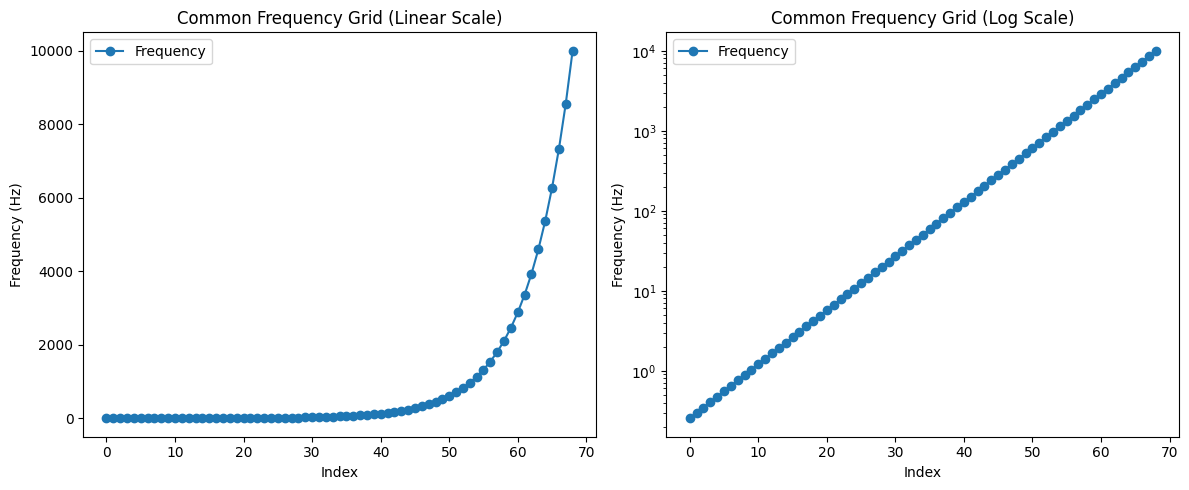

Final dataset shapes:
  X: (48, 147)
  y: (48,)
X shape: (48, 147)
y shape: (48,)


In [23]:
# Build EIS data, action data, then combine to (X, y)
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
)

print("X shape:", X.shape)
print("y shape:", y.shape)

In [24]:
# 4) Load ensemble of models from the .pkl file
models = joblib.load("../models/gb_ensemble.pkl")
# 'models' should be a list of 10 GradientBoostingRegressor objects

In [25]:
# 5) Use the ensemble to predict on X
#    For each model, predict on X, then collect results
preds_ensemble = [model.predict(X) for model in models]  # list of arrays
preds_ensemble = np.array(preds_ensemble)                # shape = (num_models, num_samples)

# 6) Compute the mean and std across the ensemble for each sample
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

# 7) Evaluate or inspect predictions
print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

# If you have ground truth y for these new data, you can evaluate error:


Mean predictions: [3898.24135504 3823.42076065 3941.66527604 3929.21126455 3922.56813386
 3899.00116921 3898.81209767 3896.18609944 3882.38985983 3891.96139155
 3869.54744878 3865.03032048 3763.85920663 3862.07485356 3855.41299258
 3830.61555649 3834.53618491 3833.00039946 3831.60976643 3725.81177481
 3796.46998795 3819.8992147  3776.99278103 3780.66987082 3781.08948625
 3764.3908695  3764.08402439 3774.17539889 3774.75251051 3756.22919645
 3756.48302442 3754.57316887 3724.69874317 3722.43993204 3724.69874317
 3725.07049222 3724.08994904 3710.00000001 3710.         3709.02736794
 3702.18736339 3703.14103206 3700.61025313 3700.51564663 3700.51729255
 3702.90610488 3689.26223442 2649.8250702 ]
Prediction std: [1.49833662e+02 1.52940448e+02 1.16599320e+01 9.08635692e+00
 3.88094007e+00 7.50793948e+00 6.55568144e+00 4.67543751e+00
 3.00320036e+00 3.84721932e+00 1.47626101e+00 2.35000272e+00
 2.17726735e+02 3.86697466e+00 1.95152858e+00 5.19600645e+00
 5.78860814e+00 5.57146726e+00 6.858436

In [26]:
rmse, r2, mse, mae = evaluate_model(y, y_pred_mean)
print(f"RMSE: {rmse} \n, R2: {r2} \n, MSE: {mse} \n, MAE: {mae}")

RMSE: 384.69807307472735 
, R2: 0.5113537376333703 
, MSE: 147992.60742740825 
, MAE: 77.6377425600469
